# データの準備

In [30]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [31]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [32]:
# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
# index を振り直す
df_wrime_target = df_wrime_target.reset_index(drop=True)

In [33]:
df_wrime_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sentence                     18237 non-null  object
 1   UserID                       18237 non-null  int64 
 2   Datetime                     18237 non-null  object
 3   Train/Dev/Test               18237 non-null  object
 4   Writer_Joy                   18237 non-null  int64 
 5   Writer_Sadness               18237 non-null  int64 
 6   Writer_Anticipation          18237 non-null  int64 
 7   Writer_Surprise              18237 non-null  int64 
 8   Writer_Anger                 18237 non-null  int64 
 9   Writer_Fear                  18237 non-null  int64 
 10  Writer_Disgust               18237 non-null  int64 
 11  Writer_Trust                 18237 non-null  int64 
 12  Reader1_Joy                  18237 non-null  int64 
 13  Reader1_Sadness              18

In [34]:
# リスト化
sentences = df_wrime_target['Sentence'].tolist()

# つぶやき分散表現

## モデル

In [35]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from transformers import BertTokenizer, BertModel

# 使用するモデルを指定して、トークナイザとモデルを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained("trained_model", output_hidden_states=True) # output_hidden_states=Trueで分散表現を取得する

## 分散表現を取得

/nの処理をしなければいけない？

In [36]:
from torch.utils.data import DataLoader

# 入力文章をトークン化する関数
def tokenize(text):
    return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# データローダーを作成する
batch_size = 64
dataloader = DataLoader(sentences, batch_size=batch_size, collate_fn=tokenize)

# モデルをGPUに移動する
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# バッチ処理で分散表現を取得する
embeddings = []
with torch.no_grad():
    for batch in dataloader:
        # バッチをGPUに移動する
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        hidden_states = outputs.hidden_states
        batch_embedding = hidden_states[-1].mean(dim=1)
        embeddings.append(batch_embedding)

embeddings = torch.cat(embeddings)

# in 1min


In [37]:
# pandasのDataFrameに変換する
df_embeddings = pd.DataFrame(embeddings.tolist())

df_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 106.9 MB


In [38]:
# # 保存する
# df_embeddings.to_csv('embeddings/fine-tuned_embeddings.tsv', sep='\t', index=False)

### 文章間の類似度

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# target_indexの文章と類似度の高い文章を表示する
target_index = 1

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 1
文　章：今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
類似度：1.0000000000000013
---
index: 5179
文　章：今回はひとりでホステルに泊まったんだけど置いていなかったのはゴシゴシタオルだけで快適すぎて住める。海外の人に英語で弁当の温め方を聞かれたけど雰囲気でなんとかオールオッケー。今朝はパンを焼いてくれたお姉さんと喋りすぎてチェックアウトに遅刻しました。手荷物預けに今から戻ります。
類似度：0.9363799699922043
---
index: 8241
文　章：この時間に麺食べるとかあまりにも罪深いことをしてしまった…幸せになった…部屋がにんにくの匂いする！
類似度：0.9336336111971982
---
index: 39
文　章：今日また、ふらりと入れる店が増えた。お酒もご飯も美味しかったし、何より、何となく温かい店だった。
類似度：0.9329526257152851
---
index: 10874
文　章：あれれ
類似度：-0.09045433237866553
---
index: 174
文　章：あー高飛びしたい。
類似度：-0.07500863553767524
---
index: 4431
文　章：そろそろ梅雨おわってくれ
類似度：-0.06906966642392574
---


---

# クラスタリング

In [40]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)
# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_

c:\Users\yossh\anaconda3\envs\bert_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


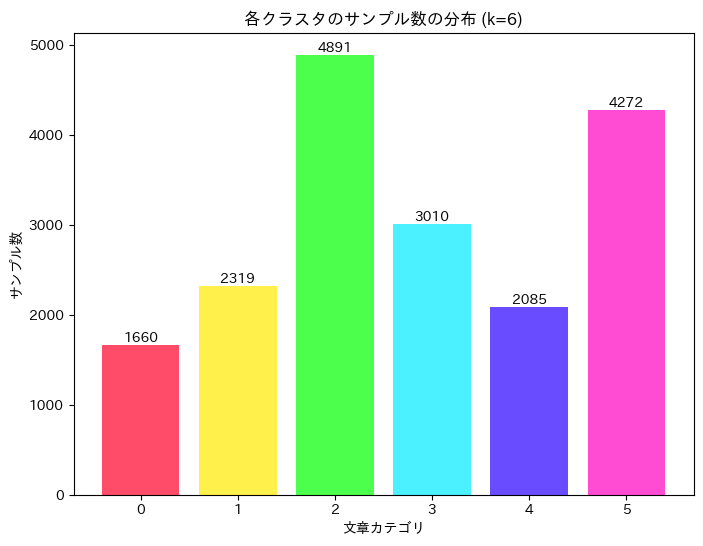

In [41]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('文章カテゴリ')
plt.ylabel('サンプル数')
plt.title(f'各クラスタのサンプル数の分布 (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

In [42]:
'''
# エルボー法による最適クラスター数の調査
SSE = []
for i in range(1, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeansModel.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), SSE, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('SSE')
plt.title('エルボー法による最適クラスター数の調査')
plt.show()
'''

"\n# エルボー法による最適クラスター数の調査\nSSE = []\nfor i in range(1, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeansModel.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(1, 40), SSE, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('SSE')\nplt.title('エルボー法による最適クラスター数の調査')\nplt.show()\n"

<img src="figures/fine-tuned_elbow.png">

### シルエット係数による最適クラスター数の調査

In [43]:
'''
from sklearn.metrics import silhouette_score

# シルエット係数による最適クラスター数の調査
silhouette_coefficients = []
for i in range(2, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('シルエット係数の平均値')
plt.title('シルエット係数の平均値による最適クラスター数の調査')
plt.show()
'''

"\nfrom sklearn.metrics import silhouette_score\n\n# シルエット係数による最適クラスター数の調査\nsilhouette_coefficients = []\nfor i in range(2, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('シルエット係数の平均値')\nplt.title('シルエット係数の平均値による最適クラスター数の調査')\nplt.show()\n"

<img src = "figures/fine-tuned_silhouette.png">

### シルエット図

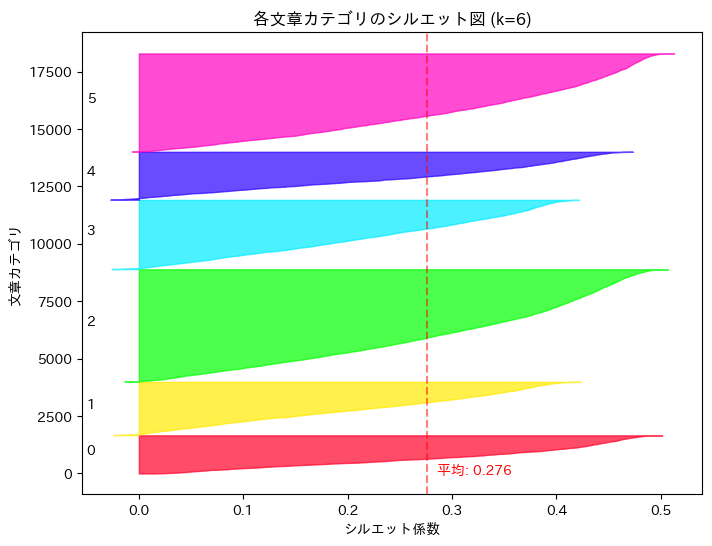

In [44]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"平均: {silhouette_avg:.3f}", color="red")

plt.xlabel('シルエット係数')
plt.ylabel('文章カテゴリ')
plt.title(f'各文章カテゴリのシルエット図 (k={k})')
plt.show()

In [45]:
# 各文章カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

文章カテゴリ: 0
シルエット係数が最も高い文章: 私(よく分かんないな…こうかな…？) 奴「わからなかったり曖昧なことはちゃんと聞いてください」 私「ここが分かりません」 奴(クソデカため息)
シルエット係数: 0.501
---
文章カテゴリ: 1
シルエット係数が最も高い文章: 知り合いの医者の奥方のお母さん（なげえ！）がパニック障害でしょっちゅう倒れるし、しぬしぬ大騒ぎが大変と聞いたことがあるけれど、わからんでもない。あの不安感。しにはしないし倒れないが、倒れるかもしれないしぬかもしれない不安はある。
シルエット係数: 0.424
---
文章カテゴリ: 2
シルエット係数が最も高い文章: この時間におうちで手作りのご飯食べ終わってるのだいぶ幸せすぎるな…
シルエット係数: 0.507
---
文章カテゴリ: 3
シルエット係数が最も高い文章: 仕事早く終わったけど\nひとりぼっち！\n仕方ないけどさみしいなー…\n今日はたくさん怒られました！
シルエット係数: 0.421
---
文章カテゴリ: 4
シルエット係数が最も高い文章: ファイアースティックってなんや？タイマツみたいなもんか？と思ったらハイテクだった。おじの家にはこんないいのあるのか
シルエット係数: 0.473
---
文章カテゴリ: 5
シルエット係数が最も高い文章: スピルバーグに会いたいです。スーパー8観たいなぁ。あと、ap当たるといいなぁどきどき。夏フェスってやつデビューしたいなぁ。
シルエット係数: 0.513
---


In [46]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 3
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    print('---')

文章カテゴリ: 3
シルエット係数が高い文章: 仕事早く終わったけど\nひとりぼっち！\n仕方ないけどさみしいなー…\n今日はたくさん怒られました！
シルエット係数: 0.421
---
文章カテゴリ: 3
シルエット係数が高い文章: 洗濯物干す前に寝ちゃった！！悔しい！！
シルエット係数: 0.417
---
文章カテゴリ: 3
シルエット係数が高い文章: いくつになっても期待してた予定のキャンセルにふてくされるの大人げないと思いながらも悲しくて
シルエット係数: 0.417
---
文章カテゴリ: 3
シルエット係数が高い文章: 10日の休み勝ち取ったのに、美容室の予約は勝ち取れませんでした。\nそして、終業間際にデータ入力ミスが発覚。\n平謝りもんですわな。\nこの落ち込んだ気持ちのまま連休に突入です。\n辛い(´･_･`)
シルエット係数: 0.416
---
文章カテゴリ: 3
シルエット係数が高い文章: ミスが多かったのも確かだけど…\nなんか悲しかったなあ\n撮影は楽しいのに悲しかったなあ\nなんで先輩と仲良く出来ないんだろう。昨日も今日も、わたしは上手く話が出来ない。。
シルエット係数: 0.416
---


## クラスタリング結果の可視化

### PCA

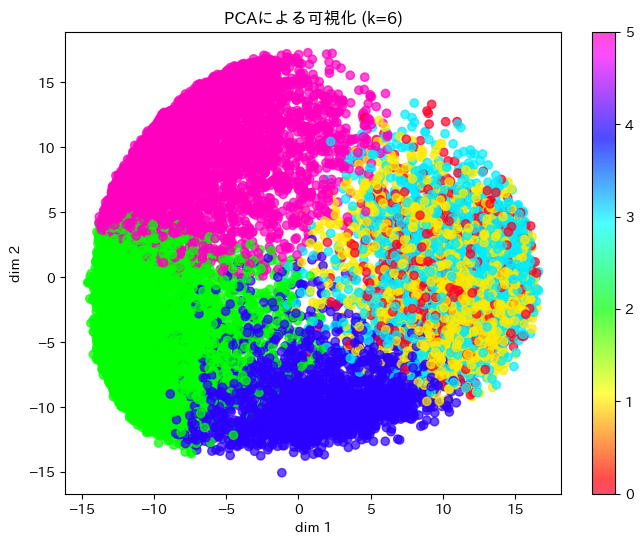

In [47]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_embeddings)
df_embeddings_pca = pca.transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_embeddings_pca[:, 0], df_embeddings_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCAによる可視化 (k={k})')
plt.colorbar()
plt.show()

### t-SNE

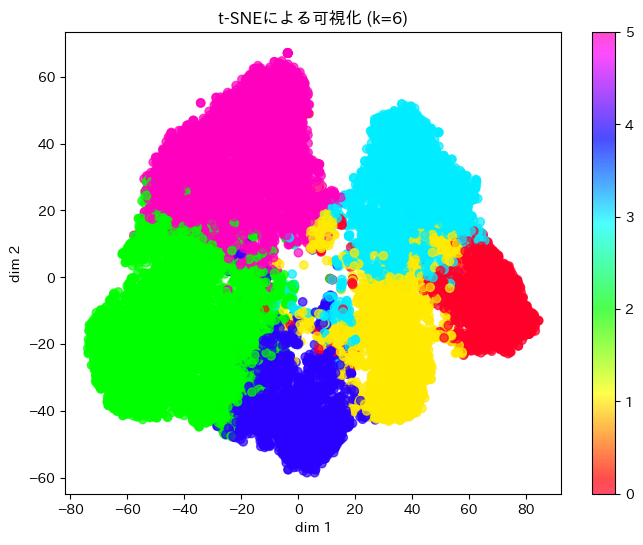

In [48]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={k})')
plt.colorbar()
plt.show()

# in 1min

### UMAP

In [49]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0)
df_wrime_features_umap = umap_obj.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAPによる可視化 (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0)\ndf_wrime_features_umap = umap_obj.fit_transform(df_embeddings)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAPによる可視化 (k={k})')\nplt.colorbar()\nplt.show()\n"

---

# 感情カテゴリとつぶやき分散表現の関係

In [50]:
# clusters/emotion_6clusters.tsvを読み込み
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
# 変換
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_emotion_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])

In [51]:
df_emotion_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


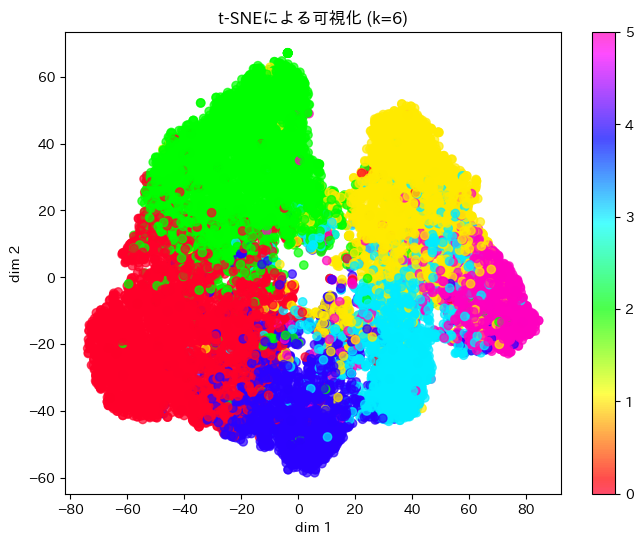

In [52]:
# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

---

### 感情カテゴリを正解ラベルとして、つぶやき分散表現から学習

In [53]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clusters], ignore_index=True, axis=1)
df_embeddings_clusters


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,-0.382917,-0.615521,-0.561328,-1.501166,-0.963259,-0.730566,1.847327,-0.347322,0.348075,...,-0.075985,-0.410857,0.465339,-0.006792,-0.616740,-0.711127,-1.756237,-1.156218,0.441140,1
1,train,0.241980,-0.829865,-0.887682,0.107739,-0.215159,-0.332007,-0.202206,0.785650,0.624457,...,-0.043099,-0.162435,-0.297075,-0.214327,-0.961610,0.251056,0.818614,-0.773976,-0.003332,4
2,train,0.517266,-1.038568,-0.140535,-0.011712,0.006431,-0.126040,-0.071153,0.762842,1.198967,...,0.177357,-0.316086,-0.094838,-0.388739,-0.730223,0.313329,0.657936,-0.798845,0.194521,0
3,train,1.240577,-0.970873,-1.078964,-0.537603,-0.459641,-0.119504,1.411326,1.141705,0.379661,...,0.625237,0.473797,-0.142584,-0.267323,-0.594057,0.830273,-2.020411,-1.460994,0.153059,2
4,train,1.299497,-0.705696,-0.029911,-0.346529,-0.311928,0.385002,-0.153364,0.878813,1.225542,...,0.770555,0.260669,-0.406372,-0.450526,-0.467411,0.489099,0.082687,-0.453224,0.006686,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,1.388751,-0.958668,-0.567128,-0.222353,-0.042948,0.631187,0.190719,0.679043,1.118653,...,1.044106,0.153405,-0.635286,-0.593725,-0.663751,0.799829,-0.301092,-1.209031,-0.105510,0
18233,train,1.160044,-1.298572,-0.834216,-0.205791,-0.252977,0.251322,-0.019735,0.486648,1.202797,...,0.692038,0.032720,-0.390509,-0.369843,-0.708857,0.787614,0.119985,-1.399304,-0.313379,2
18234,train,-0.080197,-0.703221,-0.634735,-0.065032,-0.284975,0.076891,-0.130886,0.351534,0.785133,...,0.229115,-0.177842,-0.243455,-0.490791,-0.987626,-0.115581,0.605342,-0.476586,-0.038277,0
18235,train,1.804760,-1.202803,-1.153177,-0.414115,-0.731182,0.693508,0.448281,0.923090,0.994819,...,1.208579,0.327322,-0.383081,-0.784178,-0.313203,1.283938,-1.234061,-1.082172,-0.040329,2


In [54]:
# train / test に分割する
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [55]:
import xgboost as xgb

# xgboostの入力データを作成
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.60481	test-mlogloss:1.62640
[1]	train-mlogloss:1.45854	test-mlogloss:1.49816
[2]	train-mlogloss:1.33892	test-mlogloss:1.39423
[3]	train-mlogloss:1.23849	test-mlogloss:1.30972
[4]	train-mlogloss:1.15187	test-mlogloss:1.23677
[5]	train-mlogloss:1.07645	test-mlogloss:1.17240
[6]	train-mlogloss:1.00993	test-mlogloss:1.11813
[7]	train-mlogloss:0.95122	test-mlogloss:1.07067
[8]	train-mlogloss:0.89872	test-mlogloss:1.02940
[9]	train-mlogloss:0.85156	test-mlogloss:0.99230
[10]	train-mlogloss:0.80896	test-mlogloss:0.95964
[11]	train-mlogloss:0.77046	test-mlogloss:0.92974
[12]	train-mlogloss:0.73570	test-mlogloss:0.90409
[13]	train-mlogloss:0.70411	test-mlogloss:0.87978
[14]	train-mlogloss:0.67530	test-mlogloss:0.85884
[15]	train-mlogloss:0.64914	test-mlogloss:0.83934
[16]	train-mlogloss:0.62517	test-mlogloss:0.82203
[17]	train-mlogloss:0.60323	test-mlogloss:0.80721
[18]	train-mlogloss:0.58319	test-mlogloss:0.79375
[19]	train-mlogloss:0.56472	test-mlogloss:0.78097
[20]	train

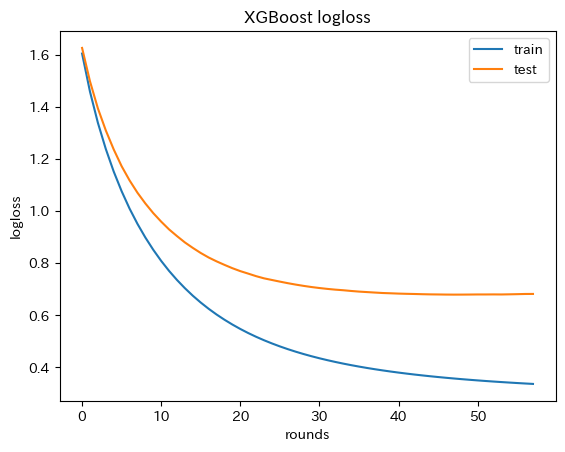

In [56]:
# モデル
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.1,
}

history = dict()

# 学習
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=10)

# 予測
preds_labels = model.predict(test_data)

# グラフ描写
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

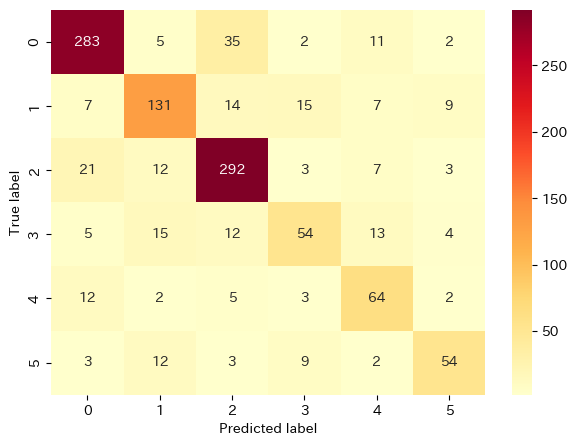

              precision    recall  f1-score   support

           0      0.855     0.837     0.846       338
           1      0.740     0.716     0.728       183
           2      0.809     0.864     0.835       338
           3      0.628     0.524     0.571       103
           4      0.615     0.727     0.667        88
           5      0.730     0.651     0.688        83

    accuracy                          0.775      1133
   macro avg      0.729     0.720     0.723      1133
weighted avg      0.774     0.775     0.773      1133



In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
fine-tuned epoch=1 は accuracy 75.6%  
fine-tuned epoch=2 は accuracy 77.3%  
fine-tuned epoch=2 は accuracy 77.5%

In [58]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

焼き肉いきたい。
True label: 1
Predicted label: 3.0
---
仕事納め!がんばろ！
True label: 2
Predicted label: 0.0
---
実家の母は、普段話し相手がいないのか、たまに帰るとむちゃくちゃ喋ってくる。今回、風邪気味で無口だったので、静かな正月となった。二泊三日の最終日、私を送り出す駅のホームで急に喋りだした。え、今？ どうやら風邪は治ったようです。
True label: 3
Predicted label: 1.0
---
ぐさりと刺さっても、笑ってスルーするー。でもやっぱり気にして髪形変えたりする。
True label: 4
Predicted label: 5.0
---
今日か明日、えべっさん行きたいな～
True label: 3
Predicted label: 2.0
---
